In [1]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d,lib.cnmem=0"%(random.randint(0,3))
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten,MaxoutDense
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
from keras.models import Model
from IPython import display

from keras.utils import np_utils


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce 920M (CNMeM is disabled, cuDNN not available)
Using Theano backend.


In [2]:
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print (np.min(X_train), np.max(X_train))

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')



0.0 1.0
X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [3]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val



In [4]:
shp = X_train.shape[1:]
dropout_rate = 0.25
opt = Adam(lr=1e-4)
dopt = Adam(lr=1e-3)

# Build Generative model ...
nch = 200
g_input = Input(shape=[100])
H = Dense(nch*14*14, init='glorot_normal')(g_input)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Reshape( [nch, 14, 14] )(H)
H = UpSampling2D(size=(2, 2))(H)
H = Convolution2D(int(nch/2), 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Convolution2D(int(nch/4), 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Convolution2D(1, 1, 1, border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()


# Build Discriminative model ...
d_input = Input(shape=shp)
H = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
encoder = Dense(40,activation='sigmoid')(H)
d_V = Dense(2,activation='softmax')(encoder)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

encoder = Model(d_input,encoder)
encoder.compile(loss='categorical_crossentropy', optimizer=dopt)
encoder.summary()

# Freeze weights in the discriminator for stacked training
make_trainable(discriminator, False)

# Build stacked GAN model
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 39200)         3959200     input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormal(None, 39200)         78400       dense_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 39200)         0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [5]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive net loss')
        plt.plot(losses["g"], label='generative adversarial net loss')
        plt.legend()
        plt.show()

In [6]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

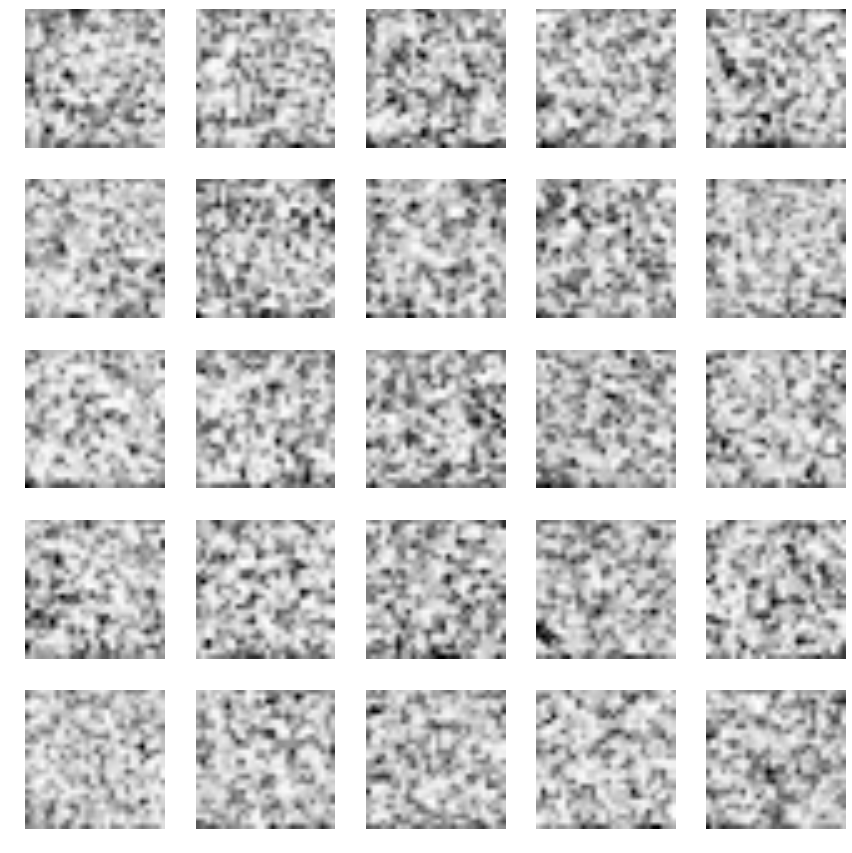

In [7]:
plot_gen(25,(5,5),(12,12))


In [8]:
ntrain = 30000
print (X_train.shape[0])
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
print (len(trainidx))
XT = X_train[trainidx,:,:,:]
print (XT.shape)


60000
30000
(30000, 1, 28, 28)


In [9]:
# Pre-train the discriminator network ...
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
print (noise_gen.shape)
generated_images = generator.predict(noise_gen)
print (generated_images.shape)

(30000, 100)
(30000, 1, 28, 28)


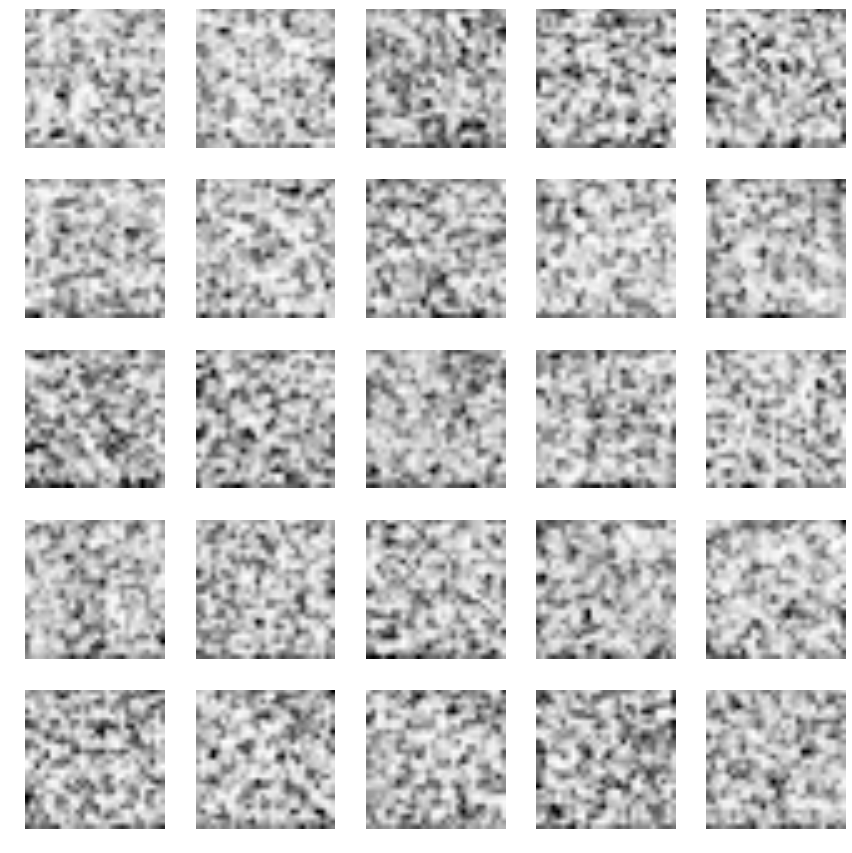

In [10]:
plot_gen(25,(5,5),(12,12))


In [11]:
X = np.concatenate((XT, generated_images))
print (X.shape)
n = XT.shape[0]
y = np.zeros([2*n,2])
print (y.shape)
y[:n,1] = 1
y[n:,0] = 1

(60000, 1, 28, 28)
(60000, 2)


In [12]:
print (y)

[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


In [13]:


make_trainable(discriminator,True)
discriminator.fit(X,y, nb_epoch=1, batch_size=128)
y_hat = discriminator.predict(X)


Epoch 1/1
60000/60000 [==============================] - 487s - loss: 0.0045   


In [14]:
y_hat.shape

(60000, 2)

In [15]:
y_hat

array([[  4.69193415e-04,   9.99530733e-01],
       [  4.69193415e-04,   9.99530733e-01],
       [  4.69193415e-04,   9.99530733e-01],
       ..., 
       [  9.99692023e-01,   3.07957118e-04],
       [  9.99692023e-01,   3.07957118e-04],
       [  9.99692023e-01,   3.07957118e-04]])

In [16]:
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print ("Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot))


Accuracy: 100.00 pct (60000 of 60000) right


In [17]:
# set up loss storage vector
losses = {"d":[], "g":[]}


In [18]:
from tqdm import tqdm


In [19]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        #print ('e ',e)
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        #print (image_batch.shape)
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        #print (noise_gen.shape)
        generated_images = generator.predict(noise_gen)
        #print (generated_images.shape)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #print ('X ',X.shape)
        y = np.zeros([2*BATCH_SIZE,2])
        #print (y)
        y[0:BATCH_SIZE,1] = 1
        #print (y)
        y[BATCH_SIZE:,0] = 1
        #print (y)
        
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        #print (noise_tr.shape)
        y2 = np.zeros([BATCH_SIZE,2])
        #print ('before assignment',y2)
        y2[:,1] = 1
        #print ('after assignment',y2)
        
        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            plot_gen()


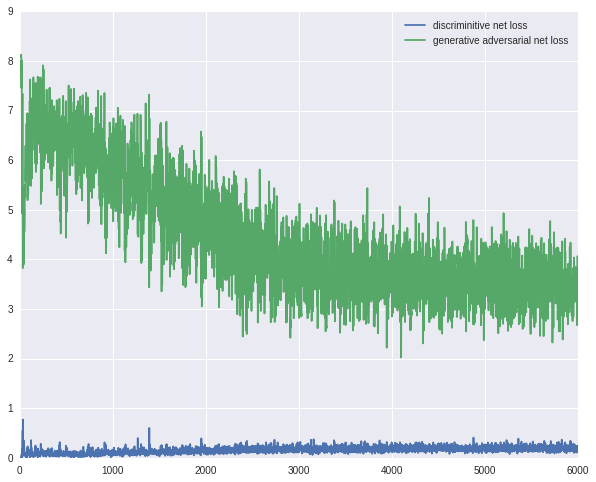

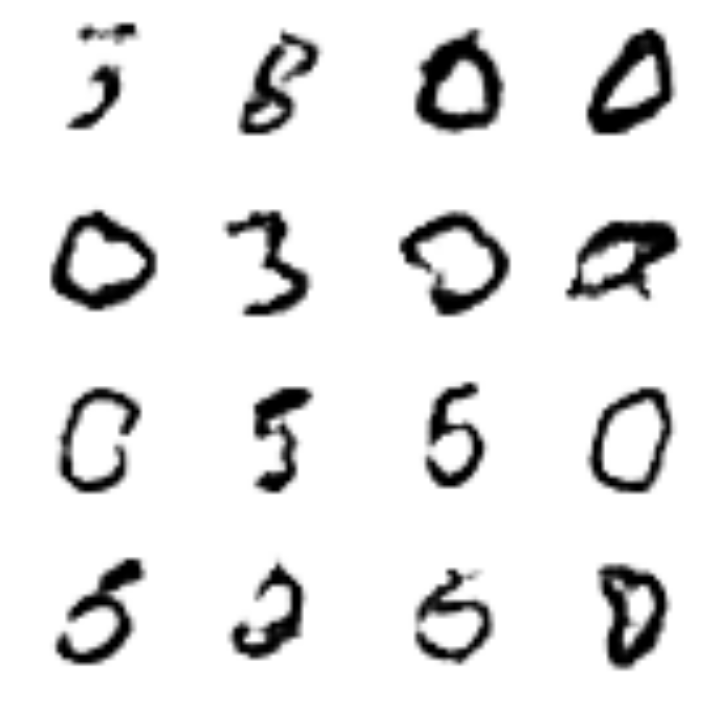

100%|██████████| 2000/2000 [1:52:45<00:00,  3.91s/it]


In [38]:
train_for_n(nb_epoch=2000, plt_frq=25,BATCH_SIZE=64)


opt.lr.set_value(1e-5)
dopt.lr.set_value(1e-6)
train_for_n(nb_epoch=100, plt_frq=10,BATCH_SIZE=256)

opt.lr.set_value(1e-4)
dopt.lr.set_value(1e-3)
train_for_n(nb_epoch=500, plt_frq=25,BATCH_SIZE=256)

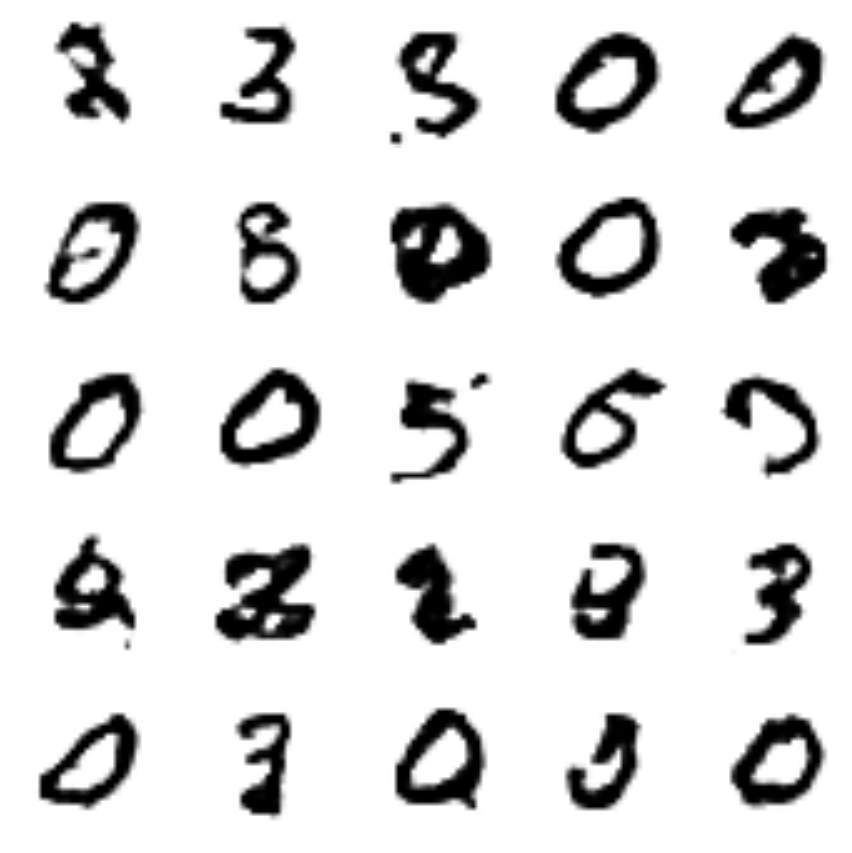

In [32]:
plot_gen(25,(5,5),(12,12))


In [22]:
def plot_real(n_ex=16,dim=(4,4), figsize=(10,10) ):
    
    idx = np.random.randint(0,X_train.shape[0],n_ex)
    generated_images = X_train[idx,:,:,:]

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

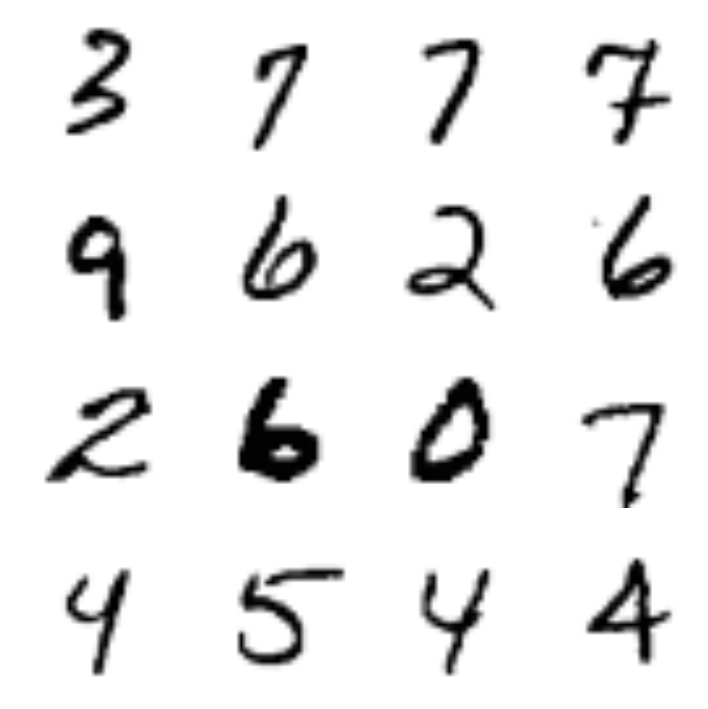

In [23]:
plot_real()


In [24]:
print (np.min(X_test), np.max(X_test))

print('X_test shape:', X_test.shape)
print(X_test.shape[0], 'train samples')


0.0 1.0
X_test shape: (10000, 1, 28, 28)
10000 train samples


In [25]:
encoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1, 28, 28)     0                                            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 256, 14, 14)   6656        input_2[0][0]                    
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 256, 14, 14)   0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 256, 14, 14)   0           leakyrelu_1[0][0]                
___________________________________________________________________________________________

In [33]:
encoded_train_imgs = encoder.predict(X_train)
print (encoded_train_imgs.size)
print (encoded_train_imgs.shape)
print (encoded_train_imgs.nbytes)

2400000
(60000, 40)
19200000


In [34]:
encoded_test_imgs = encoder.predict(X_test)
print (encoded_test_imgs.size)
print (encoded_test_imgs.shape)
print (encoded_test_imgs.nbytes)

400000
(10000, 40)
3200000


In [35]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)
clf = clf.fit(encoded_train_imgs, y_train)

In [36]:
y_pred = clf.predict(encoded_test_imgs)

In [37]:
num=len(encoded_test_imgs)
r=0
w=0
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred[i].all() == labels[i].all():
        if np.array_equal(y_pred[i],y_test[i]):
            r+=1
        else:
            w+=1
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")
# 500 epochs 10K Samples- 82.88%
#1000 epochs - 84.76%
#1500 epochs - 85.41%


# 500 epochs 30K Samples- 74.84%
# 2000 epochs 30K samples - 85.97%
# 4000 epochs 30K samples - 90.62%


tested  10000 digits
correct:  9062 wrong:  938 error rate:  9.38 %
got correctly  90.62 %
